# Transformer boilerplate code + how to use it
##### by Daniel Melchor (dmh672@gmail.com)

---
## Imports

In [48]:
import torch
import torch.nn as nn
# import pkg_resources
# pkg_resources.require("numpy==1.2.0")
# import numpy as np

import random
import math
import numpy as np
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [49]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [50]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/p/c80afbc9ffb1/
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [150]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    np.random.shuffle(data)
    
    return data

def split_data(data):
    train = []
    val = []
    test = []

    for el in data:
        pos = random.randrange(100)
        if (pos < 15):
            test.append(el)
        elif (pos >= 15 and pos < 30):
            val.append(el)
        else:
            train.append(el)
    return train, val, test

def read_graph_data():
    SOS_token = np.array([999])
    EOS_token = np.array([1000])
    PAD = -1
    
    LIST_LOCATION = './data/lists_3nodes.txt'
    RESULTS_LOCATION = './data/results_3nodes.txt'
    
    data = []
    
    with open(LIST_LOCATION) as listFile:
        with open(RESULTS_LOCATION) as resFile:
            for lis, res in zip(listFile,resFile):
                intList = list(map(int,lis[:-1].split(',')))
                resList = np.array([int(res), PAD, PAD])
                intList = np.asarray(intList)
                
                context = np.concatenate((SOS_token, intList, EOS_token))
                ans = np.concatenate((SOS_token, resList, EOS_token))
                data.append([context, ans])
                
    np.random.shuffle(data)

    return split_data(data)

def batchify_data(data, batch_size=8, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")
    print(batches)

    return batches

train_data, val_data, test_data = read_graph_data()
# train_data = generate_random_data(16)
# val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
# print(read_graph_data())
val_dataloader = batchify_data(val_data)
test_dataloader = batchify_data(test_data)

706 batches of size 8
[array([[[ 999,   14,    2,    3, 1000],
        [ 999,   16,   -1,   -1, 1000]],

       [[ 999,    3,   18,   13, 1000],
        [ 999,   30,   -1,   -1, 1000]],

       [[ 999,    5,    6,    1, 1000],
        [ 999,   10,   -1,   -1, 1000]],

       [[ 999,    6,    3,   10, 1000],
        [ 999,   14,   -1,   -1, 1000]],

       [[ 999,    7,   20,   12, 1000],
        [ 999,   34,   -1,   -1, 1000]],

       [[ 999,    2,   17,    5, 1000],
        [ 999,   22,   -1,   -1, 1000]],

       [[ 999,   16,    1,   10, 1000],
        [ 999,   24,   -1,   -1, 1000]],

       [[ 999,   16,   10,   11, 1000],
        [ 999,   34,   -1,   -1, 1000]]]), array([[[ 999,   20,   13,   15, 1000],
        [ 999,   45,   -1,   -1, 1000]],

       [[ 999,   11,   18,    8, 1000],
        [ 999,   34,   -1,   -1, 1000]],

       [[ 999,   12,   11,   10, 1000],
        [ 999,   30,   -1,   -1, 1000]],

       [[ 999,   18,    1,   11, 1000],
        [ 999,   28,   -1,   -1, 1

In [134]:
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_LOCATION = './data/data3node.txt'
train_iter = open(DATA_LOCATION, 'r').read().splitlines()
tokenizer = get_tokenizer(None)

vocab = build_vocab_from_iterator(map(tokenizer,train_iter))
model = Transformer(
    num_tokens=len(vocab), dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [135]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X.astype(np.int64)).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [136]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [145]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list
    
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 7.7493
Validation loss: 7.6073

------------------------- Epoch 2 -------------------------
Training loss: 7.6112
Validation loss: 7.4620

------------------------- Epoch 3 -------------------------
Training loss: 7.4651
Validation loss: 7.3162

------------------------- Epoch 4 -------------------------
Training loss: 7.3265
Validation loss: 7.1661

------------------------- Epoch 5 -------------------------
Training loss: 7.1650
Validation loss: 7.0114

------------------------- Epoch 6 -------------------------
Training loss: 7.0466
Validation loss: 6.8523

------------------------- Epoch 7 -------------------------
Training loss: 6.8589
Validation loss: 6.6815

------------------------- Epoch 8 -------------------------
Training loss: 6.6783
Validation loss: 6.5035

------------------------- Epoch 9 -------------------------
Training loss: 6.5100
Validation loss: 6.3142

-------

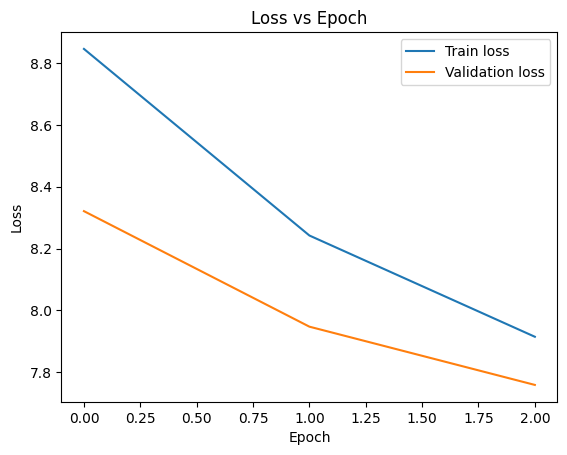

In [144]:
plt.plot(train_loss_list, label = "Train loss")
plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [153]:
def predict(model, input_sequence, max_length=15, SOS_token=999, EOS_token=1000):
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()
  
  
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[99, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(test_dataloader):
    result = predict(model, torch.tensor(example[0], dtype=torch.long, device=device))
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

IndexError: index out of range in self